<a href="https://colab.research.google.com/github/jeongmin5o/lightGBM_-/blob/main/Lpoint_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터

## 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/fc/롯데멤버스_공모전/LPOINT_BIG_COMP')
os.getcwd()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import re
import datetime

#코랩 한글깨짐 방지 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_columns',None) #

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig:

In [ ]:
#전체 데이터 돌리기

data1 = pd.read_csv('data/LPOINT_BIG_COMP_01_DEMO.csv')
data2 = pd.read_csv('data/LPOINT_BIG_COMP_02_PDDE.csv')
data3 = pd.read_csv('data/LPOINT_BIG_COMP_03_COP_U.csv')
data4 = pd.read_csv('data/LPOINT_BIG_COMP_04_PD_CLAC.csv')
data5 = pd.read_csv('data/LPOINT_BIG_COMP_05_BR.csv')
data6 = pd.read_csv('data/LPOINT_BIG_COMP_06_LPAY.csv')

## 데이터 합치기

### data2 ~ data5 합치기 (total_2345)

In [ ]:
# data2 에 없는 'vst_dt' 열 추가

data2['vst_dt'] = np.nan  # 'vst_dt' nan값으로 넣기
# 열 순서 재배열
data2 = data2[['cust','rct_no','chnl_dv','cop_c','br_c','pd_c','de_dt','de_hr','vst_dt','buy_am','buy_ct']]  

# data2와 data3을 세로로 붙이기 위해 (열기준) data3를 data2의 열이름의 갯수와 배열을 동일하게 해주기
# data3에는 없는 열 값은 nan 으로 넣기
data3['pd_c'] = np.nan   
data3['buy_ct'] = np.nan

# 다시 재배열
data3 = data3[['cust','rct_no','chnl_dv','cop_c','br_c','pd_c','de_dt','de_hr','vst_dt','buy_am','buy_ct']]

#열 기준으로 data2와 data3 합쳐주기
# 세로로 합칠땐, append함수 이용
total_23 = data2.append(data3)  # data2 밑에 data3 함수 넣기

# 'pd_c'를 기준으로 data4와 합치기
total_234 = pd.merge(total_23, data4, on=['pd_c'], how='left')  #total_23의 pd_c를 기준으로 합치기
total_234.head(3)

# 'br_c','cop_c'를 기준으로 data5와 합치기
total_2345 = pd.merge(total_234, data5, on=['br_c','cop_c'], how='left')   # 두 테이블의 중복 열이 2개이기 때문에, 만약 한개만 설정한다면 x,y 값으로 중복되어 출력됨
# 때문에, 중복되는 두 열을 기준으로 조인

### 엘페이 이용자의 인구특성:all_cust (data1 +data6)

In [ ]:
# data6의 테이블은 L페이로 구매한 데이터만 있음
# user 컬럼을 만들어, L페이 구매 여부 판단 
# L페이 구매 = 1 L페이 구매 != 0
data6['user'] = 1

# 고객번호 중복 제거한 데이터 셋 pay_user
# 중복을 제거한 이유는, L페이로 구매한 고객이냐 아니냐 정도를 파악하기 위함 
pay_user = data6.drop_duplicates(['cust'], keep='first', inplace=False, ignore_index=False)

# 고객정보를 담은 data1과 엘페이 구매유저를 담은 pay_user와 결합하여
# L페이로 구매한 경험이 있는 고객인지 아닌지를 파악하는 테이블 생성
all_cust = pd.merge(data1, pay_user, on='cust', how='left')  #all_cust : 했나 안했나

# 필요없는 컬럼 제거
all_cust.drop(['rct_no','cop_c','chnl_dv','de_dt','de_hr','buy_am'], axis=1, inplace=True)

In [ ]:
# all_cust csv파일로 추출
# all_cust.to_csv('all_cust.csv', index=False) 

In [ ]:
# L페이 구매내역과 고객정보를 합쳐서, L페이 이용 고객들의 정보 확인 
pay_list = pd.merge(data1, data6, on='cust', how='inner')

### 전체데이터: c_ana(all_cust + total_2345)
| 제휴사, 비제휴사(L00, L001) 제외한 데이터

In [ ]:
c_ana = pd.merge(total_2345, all_cust, on='cust', how='left')

In [ ]:
# c_ana csv파일로 추출
# c_ana.to_csv('final.csv', index=False) 

In [ ]:
c_ana.rename(columns = {'zon_hlv_x': 'buy_zon', 'zon_hlv_y' : 'live_zon'}, inplace=True)

## 데이터 설명 & EDA(간단한 코드 이외에는 모두 데이터 관련 내용이라 삭제하였습니다.)

# 데이터 전처리

In [ ]:
c_ana = pd.read_csv('data/final.csv')
c_ana.rename(columns={'user': 'Lpay_user'}, inplace = True)

In [ ]:
#1000원 미만 제거 -> 이 금액들은 추가 지불 등 특수 사례로 추측하며, 마케팅 가치가 없다고 판단

c_ana_drop_6 = c_ana.copy()
c_ana_drop_6 = c_ana_drop_6[c_ana_drop_6['buy_am'] >= 1000]
c_ana_drop_6 = c_ana_drop_6[c_ana_drop_6['de_dt'] >= '2021-01-01']


# 금융/보험 서비스, 기타상품, 기타(비상품), 담배, 여행/레저 서비스 대분류 제거
# 컴퓨터, 모바일, 계절가전, 냉장/세탁가전 등 1회성 구매 이후 장기간 구매 안 할 물품들 제거

c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '금융/보험서비스']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '기타상품']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '기타(비상품)']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '담배']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '테넌트/음식점']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '컴퓨터']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '모바일']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '계절가전']
c_ana_drop_6 =  c_ana_drop_6[c_ana_drop_6['clac_hlv_nm'] != '냉장/세탁가전']

In [ ]:
# 불필요한 컬럼 제거
c_ana_drop_6 = c_ana_drop_6.drop([ 'br_c', 'pd_c', 'pd_nm','clac_mcls_nm','vst_dt'], axis = 1) 

In [ ]:
# 시간 데이터 나누기
# de_dt -> year, month, day, weekday
c_ana_drop_6['de_dt'] = pd.to_datetime(c_ana_drop_6['de_dt'])
c_ana_drop_6['year'] = c_ana_drop_6['de_dt'].dt.year
c_ana_drop_6['month'] = c_ana_drop_6['de_dt'].dt.month
c_ana_drop_6['day'] = c_ana_drop_6['de_dt'].dt.day
c_ana_drop_6['weekday'] = c_ana_drop_6['de_dt'].dt.weekday #0: 월요일 

## 테이블 나누기(A & ETC)

In [ ]:
# 제휴사 A (온/ 오프라인 A01~06)
A =  c_ana_drop_6[c_ana_drop_6['cop_c'].str.contains('A')]

# 제휴사 ETC( 온오프라인 B~E )
ETC = c_ana_drop_6[c_ana_drop_6['cop_c'].str.contains('A')== False]

## A 제휴사

In [ ]:
A.drop(['year','zon_mcls'], axis=1, inplace=True)

# A.drop(['buy_zon'], axis=1, inplace=True)

### clac 나누기

> 대분류 그룹핑
59개 대분류를 8개로

|  |clac_hlv_nm|
|--|--|
|1. 스포츠|스포츠패션, 아웃도어/레저, 시즌스포츠, 구기/필드스포츠, 헬스/피트니스|
|2. 케어| 퍼스널케어, 화장품/뷰티케어,건강용품|
|3. 식품 및 식재료| 조미료, 채소, 양곡, 병통조림, 수산물, 축산물,건해산물 , 냉동식품 ,대용식, 조리식품, 냉장식품,  과일, 과자, 주류, 음료, 커피/차, 유제품, 건강식품|
|4.  의류 | 여성의류, 패션잡화, 남성의류|
|5. 육아용품| 출산/육아용품, 유아식품, 유아동의류 |
|6. 가전 및 가구|  생활/주방가전, 모바일,영상/음향가전, 서적/음반/악기, 컴퓨터,가구, 침구/수예, 계절가전, 냉장/세탁가전, 인테리어/조명|
|7. 생활잡화|청소/세탁/욕실용품, 세제/위생, 주방잡화, 원예/애완, 식기/조리기구,속옷/양말/홈웨어|
|8 기타| 완구, 문구/사무용품, 테넌트/음식점, 생활/렌탈서비스, 상품권, 자동차용품, 공구/안전용품, 기타(비상품), 기타상품, 금융/보험서비스, 담배|

* '테넌트/음식점, 모바일, 계절 가전, 컴퓨터, 냉장/세탁가전' 은 제외




In [ ]:
c_ana['clac_hlv_nm'].unique()

array(['남성의류', '주방잡화', '테넌트/음식점', '속옷/양말/홈웨어', '구기/필드스포츠', '여성의류', '음료',
       '아웃도어/레저', '유아동의류', '패션잡화', '스포츠패션', '식기/조리기구', '과자', '조리식품',
       '침구/수예', '대용식', '헬스/피트니스', '서적/음반/악기', '생활/렌탈서비스', '조미료', '주류',
       '수산물', '완구', '채소', '유아식품', '시즌스포츠', '과일', '상품권', '냉장식품', '냉동식품',
       '축산물', '자동차용품', '화장품/뷰티케어', '커피/차', '계절가전', '가구', '건강식품',
       '영상/음향가전', '양곡', '유제품', '생활/주방가전', '냉장/세탁가전', '여행/레저서비스', '세제/위생',
       '퍼스널케어', '컴퓨터', '문구/사무용품', '모바일', '원예/애완', '병통조림', '건강용품',
       '출산/육아용품', '공구/안전용품', '건해산물', '인테리어/조명', '청소/세탁/욕실용품', '기타(비상품)',
       '담배', '기타상품', '금융/보험서비스', nan], dtype=object)

In [ ]:
A['clac'] = "others"

#가격군별로 다시 묶기 특히, 의류

#스포츠
A.loc[A['clac_hlv_nm'] == '스포츠패션','clac'] = '스포츠'
A.loc[A['clac_hlv_nm'] == '아웃도어/레저','clac'] = '스포츠'
A.loc[A['clac_hlv_nm'] == '시즌스포츠','clac'] = '스포츠'
A.loc[A['clac_hlv_nm'] == '구기/필드스포츠','clac'] = '스포츠'
A.loc[A['clac_hlv_nm'] == '헬스/피트니스','clac'] = '스포츠'


 #케어
A.loc[A['clac_hlv_nm'] == '퍼스널케어','clac' ] ='케어'
A.loc[A['clac_hlv_nm'] == '화장품/뷰티케어','clac' ] ='케어'
A.loc[A['clac_hlv_nm'] == '건강용품','clac'] = '케어'

#식품
A.loc[A['clac_hlv_nm'] == '조미료','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '채소','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '양곡','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '병통조림','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '수산물','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '축산물','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '건해산물','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '냉동식품','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '대용식','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '조리식품','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '냉장식품','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '과일','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '과자','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '주류','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '음료','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '커피/차','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '유제품','clac' ] ='식품 및 식재료'
A.loc[A['clac_hlv_nm'] == '건강식품','clac' ] ='식품 및 식재료'


# 의류
A.loc[A['clac_hlv_nm'] == '여성의류','clac' ] ='의류'
A.loc[A['clac_hlv_nm'] == '패션잡화','clac' ] ='의류'
A.loc[A['clac_hlv_nm'] == '남성의류','clac' ] ='의류'

# 육아용품
A.loc[A['clac_hlv_nm'] == '출산/육아용품','clac' ] ='육아용품'
A.loc[A['clac_hlv_nm'] == '유아식품','clac' ] ='육아용품'
A.loc[A['clac_hlv_nm'] == '유아동의류','clac' ] ='육아용품'

# # 가전 및 가구
A.loc[A['clac_hlv_nm'] == '생활/주방가전','clac' ] ='가전 및 가구'
A.loc[A['clac_hlv_nm'] == '영상/음향가전','clac' ] ='가전 및 가구'
A.loc[A['clac_hlv_nm'] == '서적/음반/악기','clac' ] ='가전 및 가구'
A.loc[A['clac_hlv_nm'] == '가구','clac' ] ='가전 및 가구'
A.loc[A['clac_hlv_nm'] == '침구/수예','clac' ] ='가전 및 가구'
A.loc[A['clac_hlv_nm'] == '인테리어/조명','clac' ] ='가전 및 가구'


# 생활잡화
A.loc[A['clac_hlv_nm'] == '청소/세탁/욕실용품','clac' ] ='생활잡화'
A.loc[A['clac_hlv_nm'] == '세제/위생','clac' ] ='생활잡화'
A.loc[A['clac_hlv_nm'] == '주방잡화','clac' ] ='생활잡화'
A.loc[A['clac_hlv_nm'] == '원예/애완','clac' ] ='생활잡화'
A.loc[A['clac_hlv_nm'] == '식기/조리기구','clac' ] ='생활잡화'
A.loc[A['clac_hlv_nm'] == '속옷/양말/홈웨어','clac' ] ='생활잡화'


#기타
A.loc[A['clac_hlv_nm'] == '완구','clac' ] ='기타'
A.loc[A['clac_hlv_nm'] == '문구/사무용품','clac' ] ='기타'
A.loc[A['clac_hlv_nm'] == '생활/렌탈서비스','clac' ] ='기타'
A.loc[A['clac_hlv_nm'] == '상품권','clac' ] ='기타'
A.loc[A['clac_hlv_nm'] == '자동차용품','clac' ] ='기타'
A.loc[A['clac_hlv_nm'] == '공구/안전용품','clac' ] ='기타'



# 대분류 드롭

A.drop(['clac_hlv_nm'], axis=1, inplace=True)

### 이상치 제거

In [ ]:
# 이상치 제거
from collections import Counter

# Outlier detection 

def detect_outliers(df,features, multiple):

  outlier_indices = []
  
  # iterate over features(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col],75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1
    
    # outlier step
    outlier_step = multiple  * IQR
    
    
    # Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
    # append the found outlier indices for col to the list of outlier indices 
    outlier_indices.extend(outlier_list_col)

  outlier_indices = Counter(outlier_indices)
  return outlier_indices

# 분류별 이상치 제거
clac_list = ['의류', '생활잡화', '기타', '스포츠', '식품 및 식재료', '육아용품', '가전 및 가구', '케어']


for i in clac_list :
  ddd = A[ A['clac'] == i]
  Outliers_to_drop = detect_outliers( ddd, ['buy_am'],10) 
  A = A.drop(Outliers_to_drop)

# 일반적으로 multiple 1.5배이지만, 너무 많은 양의 이상치가 지워지므로, 10배로 지정하였다.

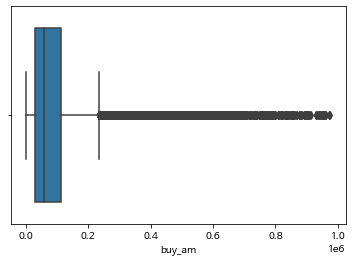

In [ ]:
# 이상치 제거 전의 boxplot
sns.boxplot(A[A['clac'] == '스포츠']['buy_am'])

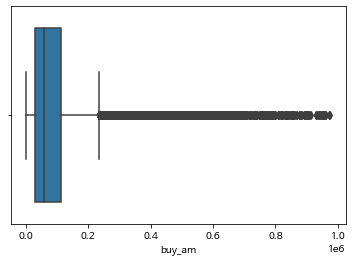

In [ ]:
# 이상치 제거 후의 boxplot
sns.boxplot(A[A['clac'] == '스포츠']['buy_am'])

### 데이터 나누기

< 문제정의 >

1.   고객의 구매 행동이 발생하는 시간대 예측
    -> 어떤 고객이, 몇시에 어떤 품목에 대한 구매가 발생할 것인가



- 정규화 시키기
이산형 데이터('buy_am')의 분포가 정규화 되어있지 않기 때문에 이를 정규화 시키는 과정이 필요. 

In [ ]:
# 'buyer' 열 만들기 : 스포츠를 산다 1, 안산다 0 
A['sports'] = np.where(A['clac'] == '스포츠', 1, 0)

## ETC

In [ ]:
ETC = c_ana_drop_6[c_ana_drop_6['cop_c'].str.contains('A')== False]

In [ ]:
# cop_c 별로 묶기
ETC['B'] = 0
ETC['C'] = 0
ETC['D'] = 0
ETC['E'] = 0


# 각 제휴사를방문했으면 1, 아니면 0
ETC.loc[ETC['cop_c'].str.contains('B'),'B'] = 1
ETC.loc[ETC['cop_c'].str.contains('C'),'C'] = 1
ETC.loc[ETC['cop_c'].str.contains('D'),'D'] = 1
ETC.loc[ETC['cop_c'].str.contains('E'),'E'] = 1

In [ ]:
# 고객 별로 A제휴사를 제외한 기타 제휴사 별 구매한 횟수
ETC = ETC.groupby('cust')['B','C','D','E'].sum()
ETC.head(2)

,B,C,D,E
cust,,,,
M000034966,0,0,1,0
M000059535,0,1,0,0


## A & ETC 합치기

In [ ]:
sports = pd.merge(A,ETC, how='left',on=['cust'])

In [ ]:
sports['buy_zon']= sports['buy_zon'].fillna('N')

In [ ]:
# B,C,D,E의 null값은 구매하지 않았기에 0으로 대체
sports['B'] = sports['B'].fillna(0)
sports['C'] = sports['C'].fillna(0)
sports['D'] = sports['D'].fillna(0)
sports['E'] = sports['E'].fillna(0)

In [ ]:
sports.isnull().sum().sum()

0

## buy_am 정규화

15630.21458229683 59402.789483746135


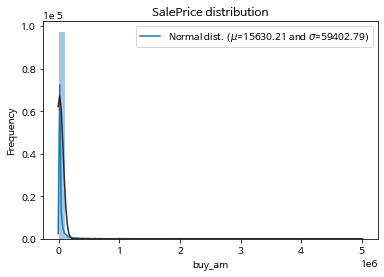

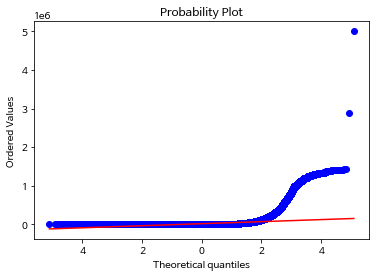

In [ ]:
# 정규화 전처리

from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(sports['buy_am'], fit=norm)

(mu, sigma) = norm.fit(sports['buy_am'])
print(mu, sigma)

# 분포 그래프
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#qq-plot
fig = plt.figure()
res = stats.probplot(sports['buy_am'], plot=plt)
plt.show()

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['buy_am'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['buy_am'], axis=1, inplace=True)
    return df_copy

In [ ]:
sports = get_preprocessed_df(df=sports)


# RFM

### recency_data = 현재 날짜 - 고객 ID별 가장 마지막 구매일
- 현재날짜를 maxdate로()('2021-12-31')로 가정

In [ ]:
sports_rfm = sports[(sports['clac'] == '스포츠')]

In [ ]:
recency_data = sports_rfm.groupby('cust',as_index= False )['de_dt'].max()  #as_index: reset_index 랑 동일
recency_data.columns = ['CustomerID', 'LastPurchaseDate']

*** 현재날짜변경***

In [ ]:
# 현재날짜를 maxdate로()('2021-12-31')로 가정
recency_data['Recency'] = recency_data['LastPurchaseDate'].apply(lambda x: (sports_rfm['de_dt'].max() - x).days)


In [ ]:
recency_data.drop(columns =['LastPurchaseDate'],inplace = True )

### Frequency(최빈성)

- invoiceNo(rct_no와 동일): 다양한 물품을 구매해도, 송장번호가 한개면 한번 구매한것으로 여김

In [ ]:
frequency_data = sports_rfm.copy()

# 어떤 물품을 구매했는지가 아니라, 한 사람한테 몇개의 영수증번호가 있는지 매칭 
frequency_data.drop_duplicates(subset = ['cust','rct_no'], keep = 'first',inplace = True)

frequency_data = frequency_data.groupby('cust', as_index = False)['rct_no'].count()
frequency_data.columns = ['CustomerID','Frequency']

### Monetary (금액)

In [ ]:
monetary_data=c_ana.groupby('cust',as_index=False)['buy_am'].sum()
monetary_data.columns = ['CustomerID','Monetary']

merge 해주기 (recency + frequency + monetary)

In [ ]:
rf = recency_data.merge(frequency_data, how = 'left', on='CustomerID')
rfm = rf.merge(monetary_data, how = 'left', on='CustomerID')

### 스케일링 (minmax)
- minmax_scale: 최대값을 1. 최소값을 0으로 표준화 하는 기법
- RFM을 하나의 점수로 환산시켜야 함
- 현재 각각의 단위가 다르기 때문에 각 컬럼별 기준으로 표준화 필요

In [ ]:
from sklearn.preprocessing import minmax_scale

## 최근성: 숫자가 작을수록 좋음
# 즉, 최근 구매일이 얼마 지나지 않은 고객이 더 점수가 높음

rfm['Recency'] = minmax_scale(rfm['Recency'], axis = 0, copy = True )
#행기준으로, 카피해서 만들기
rfm['Recency'] = 1 - rfm['Recency']  # 작은값이 좋기 때문에, 1에서 빼줌(반전)

rfm['Frequency'] = minmax_scale(rfm['Frequency'], axis = 0, copy = True )

rfm['Monetary'] = minmax_scale(rfm['Monetary'], axis = 0, copy = True )


In [ ]:
# score
rfm['Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']

# score 에 minmax_scale 적용
# 100을 곱해서 100점 만점으로 스케일링

rfm['Score'] = minmax_scale(rfm['Score'], axis = 0, copy = True) * 100

rfm['Score'] = round(rfm['Score'], 0)

데이터 merge : sports + rfm

In [ ]:
sports = sports.merge(rfm, left_on = 'cust', right_on = 'CustomerID', how='left')

In [ ]:
sports = sports.fillna('0')

In [ ]:
# null값 없음
sports.isnull().sum().sum()

0

In [ ]:
# 필요없는 열 삭제

sports.drop(['clac','live_zon','rct_no','de_dt','CustomerID'], axis=1, inplace=True)

In [ ]:
sports.drop(['Recency','Frequency','Monetary'], axis=1, inplace=True)

In [ ]:
sports['Score'] = sports['Score'].astype('float') # Score str -> float

# 모델링

## train_valid, test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score, confusion_matrix, recall_score, precision_score


# 스포츠를 산다 1, 안산다 0 (y값)
X = sports.drop(['sports'], axis=1)
y = sports['sports']

# train, test 나누기
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)


# 1. test 데이터에서 cust_ID 나누기
test_id = X_test['cust'] 

# 2. X_test에서  cust_ID 삭제
X_test.drop(['cust'], axis=1, inplace=True)

# 3. X_train_valid 데이터에서 ID 삭제
X_train_valid.drop(['cust'], axis=1, inplace=True)

## Feature Engineer

In [ ]:
# OneHot Encoding 

X_train_valid = pd.get_dummies(X_train_valid)

# 모델링 이후 test 할 때를 위해 get_dummies
X_test_copy = pd.get_dummies(X_test)

## train, valid set 나누기

In [ ]:
# X_train_test 에서 train 과 test 나누기
# X_train, y_train
# X_valid, y_valid
X_train , X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.25, random_state = 1234, stratify=y_train_valid)

##  SMOTE 오버 샘플링



In [ ]:
# y값의 분포가 매우 불균형하여 smote기법으로 오버 샘플링 이후 모델에 적용

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트:  (2135712, 45) (2135712,)
SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트:  (4177498, 45) (4177498,)
SMOTE 적용 후 레이블 값 분포: 
 0    2088749
1    2088749
Name: sports, dtype: int64


## 모델 예측 성능

In [ ]:
# lightgbm
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)

In [ ]:
lgbm_clf.fit(X_train_over, y_train_over)

In [ ]:
pred = lgbm_clf.predict(X_valid)
pred_proba = lgbm_clf.predict_proba(X_valid)[:,1]

In [ ]:
from sklearn.metrics import roc_auc_score,f1_score, accuracy_score

accuracy = accuracy_score(y_valid, pred)
roc_auc = roc_auc_score(y_valid, pred_proba)

print(f'정확도:{accuracy}, AUC:{roc_auc}')

정확도:0.961271517969392, AUC:0.9629518213276089


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

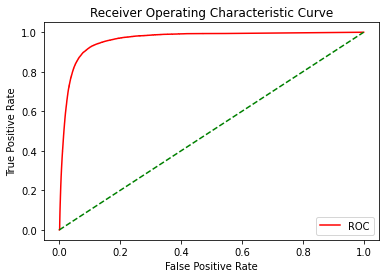

In [ ]:
from sklearn.metrics import roc_curve
pred_proba = lgbm_clf.predict_proba(X_valid)[:,1]
fper, tper, thresholds = roc_curve(y_valid, pred_proba)
plot_roc_curve(fper, tper)

In [ ]:
test_pred = lgbm_clf.predict(X_test_copy)

In [ ]:
result = pd.DataFrame({'cust_id' : test_id, 'purchase' : test_pred})

In [ ]:
X_test = X_test[['month','day','weekday']]

In [ ]:
import joblib

In [ ]:
joblib.dump(lgbm_clf, './3.데린이_데이터 및 모델 세이브 파일.pkl')

['./3.데린이_데이터 및 모델 세이브 파일.pkl']